In [28]:
import pandas as pd
pd.options.display.max_rows = 1000 
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import abstract
import yfinance as yf
import datetime

In [64]:
data = yf.download(tickers= 'NVDA', start= '2014-01-01', end= '2024-12-29')
# Ensure index is datetime
data.index = pd.to_datetime(data.index)
# Remove 'BTC-USD' level from the columns
data.columns = data.columns.droplevel('Ticker')

[*********************100%***********************]  1 of 1 completed


In [66]:
resampled_data = data.resample('W').agg({'Close': 'last','High': 'max','Low': 'min','Open': 'first','Volume': 'sum'})

In [68]:
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,0.373966,0.376796,0.370665,0.375381,260092000
2014-01-03,0.369486,0.375381,0.368307,0.374674,259332000
2014-01-06,0.374438,0.377267,0.369722,0.373259,409492000
2014-01-07,0.380568,0.381983,0.375617,0.378210,333288000
2014-01-08,0.385756,0.387642,0.380568,0.381983,308192000
...,...,...,...,...,...
2024-12-20,134.699997,135.279999,128.220001,129.809998,306528600
2024-12-23,139.669998,139.789993,135.119995,136.279999,176053500
2024-12-24,140.220001,141.899994,138.649994,140.000000,105157000


In [70]:
# Ensure `data` is a DataFrame with necessary columns
# Replace `data` with your DataFrame variable
data['MACD'], data['Signal'], data['Histogram'] = talib.MACD(
    data['Close'], 
    fastperiod=3, 
    slowperiod=21, 
    signalperiod=9
)

data['Entry Price'] = data['Open'].shift(-1)
data['Exit Price'] = data['Close'].shift(-1)
data['Nxt High'] = data['High'].shift(-1)
data['Nxt Low'] = data['Low'].shift(-1)
data['Entry Signal'] = (data['Histogram'] > 0) & (data['Histogram'].shift(1) < 0)
data['SL-TGT'] = np.where((data['Nxt Low'] <= data['Low']), 'SL HIT', 'TGT')
data['SL-POINTS'] = data['Entry Price'] - data['Low']
data['Points'] = np.where(
    data['SL-TGT'] == 'TGT', 
    data['Close'].shift(-1) - data['Open'].shift(-1), 
    data['SL-POINTS']
)

In [72]:
trades = data[data['Entry Signal'] == True].copy()
trades['Cumulative'] = trades['Points'].cumsum()
trades['IsWin'] = (trades['SL-TGT'] == 'TGT').astype(int)
trades['WinStreak'] = trades['IsWin'].groupby(
    (trades['IsWin'] != trades['IsWin'].shift()).cumsum()
).cumsum() * trades['IsWin']
trades['IsLoss'] = (trades['SL-TGT'] == 'SL HIT').astype(int)
trades['LossStreak'] = trades['IsLoss'].groupby(
    (trades['IsLoss'] != trades['IsLoss'].shift()).cumsum()
).cumsum() * trades['IsLoss']
trades['Peak'] = trades['Cumulative'].cummax()
trades['Drawdown'] = trades['Peak'] - trades['Cumulative']

In [76]:
profit = trades[trades['SL-TGT'] == 'TGT']
loss = trades[trades['SL-TGT'] == 'SL HIT']

average_profit = profit['Points'].mean()
average_loss = loss['Points'].mean()

total_pnl = abs(trades['Points'].sum())
max_profit = abs(trades['Points'].max())
max_loss = abs(trades['Points'].min())
total_trades = len(trades)
average = abs(total_pnl / total_trades)
max_drawdown = abs(trades['Drawdown'].max())
win_rate = abs(len(profit) / total_trades)
win_streak = trades['WinStreak'].max()
loose_streak = trades['LossStreak'].max()
loss_rate = abs(len(loss) / total_trades)
expectancy = (win_rate * average_profit) - (loss_rate * average_loss)

metrics = {
    'Total Profit': total_pnl,
    'Total Trades': total_trades,
    'Maximum Drawdown': max_drawdown,
    'Max Profit': max_profit,
    'Max Loss': max_loss,
    'Win Rate': win_rate * 100,
    'Win Streak': win_streak,
    'Losing Streak': loose_streak,
    'Loss Percentage': loss_rate * 100,
    'Average': average,
    'Average Profit': average_profit,
    'Average Loss': average_loss,
    'Expectancy': expectancy
}

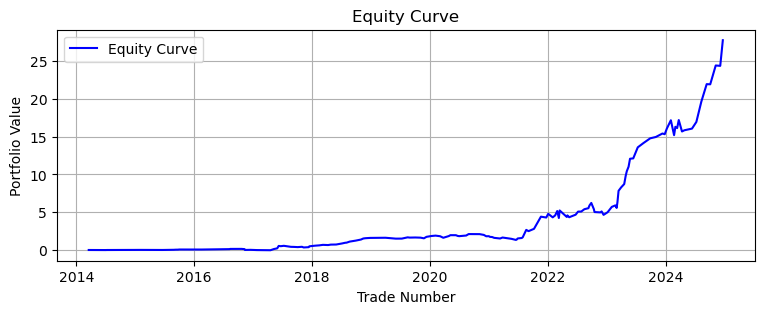

In [78]:
plt.figure(figsize=(9, 3))
plt.plot(trades['Cumulative'], label='Equity Curve', color='blue')
plt.title('Equity Curve')
plt.xlabel('Trade Number')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show()

In [80]:
for metric, value in metrics.items():
    print(f'{metric}: {value}')

Total Profit: 27.74666983382874
Total Trades: 189
Maximum Drawdown: 1.972440371380273
Max Profit: 3.3899993896484375
Max Loss: 1.972440371380273
Win Rate: 80.95238095238095
Win Streak: 22
Losing Streak: 3
Loss Percentage: 19.047619047619047
Average: 0.14680777689856475
Average Profit: 0.1394218247492005
Average Loss: 0.17819807353336287
Expectancy: 0.07892279650490272


In [82]:
# Trades where SL was hit
sl_hits = trades[trades['SL-TGT'] == 'SL HIT']
print(sl_hits)

# Trades where target was hit
targets = trades[trades['SL-TGT'] == 'TGT']
print(targets)

Price           Close       High        Low       Open      Volume      MACD  \
Date                                                                           
2014-07-02   0.444486   0.446390   0.441869   0.444486   179284000 -0.003677   
2014-08-06   0.419740   0.424975   0.414267   0.417360   223456000 -0.011650   
2014-10-08   0.436414   0.438565   0.424703   0.428049   260172000 -0.010634   
2015-01-09   0.478583   0.482183   0.471863   0.478343   209540000 -0.006303   
2015-03-17   0.560176   0.560417   0.548370   0.552225   299900000  0.016522   
2015-03-20   0.565476   0.568850   0.558730   0.564031   462084000  0.017033   
2015-05-07   0.541865   0.543552   0.528613   0.530300   534564000  0.002184   
2015-05-18   0.512470   0.515603   0.509579   0.511989   324972000 -0.010317   
2015-06-18   0.531060   0.534449   0.525251   0.526703   299404000  0.001863   
2015-07-13   0.481198   0.483860   0.478051   0.482892   212472000 -0.017432   
2015-07-23   0.475630   0.482650   0.469